In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 

import mne

%matplotlib widget

!date -I

2024-02-19


Ahoj Katko - zkus prosimte si trochu pohrat s tim prahovanim - mozna bude davat smysl globalni normalizace, misto po jednotlivych ROI. V podstate jde o to, aby pred stimulaci nebyla zadna signifikantni aktivace a odpoved po stimulaci byla co nejcistsi. Viz procedura v klasickem PCI (https://doi.org/10.1126/scitranslmed.3006294), maji to popsane v appendixu. Neni treba vymyslet robustni algoritmus, spis inspirace pro rucni volbu prahu. 

Co by mi taky davalo smysl je si ROI seradit v carpet plotu podle jednotlich komunikacnich metrik aplikovanych na SC a pak se podivat jestli ty odezvy (at uz simulovane nebo empiricke) tohle razeni v nejake forme nerespektuji (napr. prvni peak, nebo nejvetsi peak, ....).

Co zkouším a jak to jde

- našla jsem si chybu v baseline correction
    - https://mne.tools/stable/generated/mne.baseline.rescale.html
    - můžu použít mode='zscore'
        - inspirace: "First, each source’s activity was centralized and normalized on the mean and standard deviation of its baseline level (from -500 to -1 ms)." [A Theoretically Based Index of Consciousness Independent of Sensory Processing and Behavior, Supplementary Material] (*ten popis, jak to dělali, pokračuje dalšími kroky, které bych taky mohla zkusit*)    
- hezčí notebook, aby to tu bylo všechno vidět - no, nějak...


TODO nápady

- globální normalizace
- korelace s průměrem odpovědi, se std odchylkou odpovědi
- PCA před tím vším - čistší data?
- A Theoretically Based Index of Consciousness... - pokračovat v postupu, který popisují

TODO z konzultace 19. 2.

- zkusit se simulovanými daty
- zkusit def. odpovědi jako v článku s modularitou
- kouknout na notebook od Honzy

In [90]:
def plot_data(data,title=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data);
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,title=None,constants=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants:
        plt.plot([c]*400)
    plt.show()

## Load data

### Load pytepfit data

In [91]:
empirical = np.load('../data/external/pytepfit/source_estimates/simulated.npz')
empirical['ts'].shape

(400, 200)

In [92]:
empirical['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [93]:
empirical['labels'].shape

(200,)

In [94]:
empirical['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

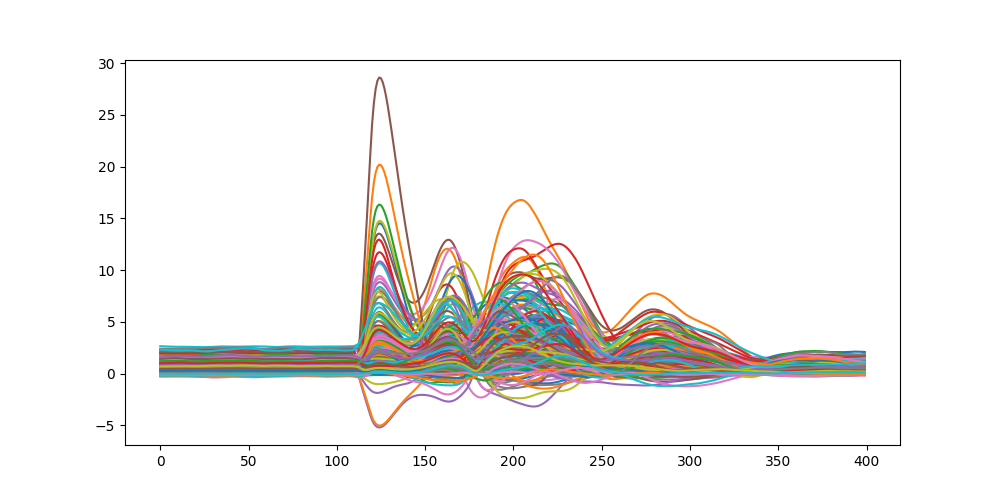

In [95]:
plot_data(empirical['ts'])

Applying baseline correction (mode: zscore)


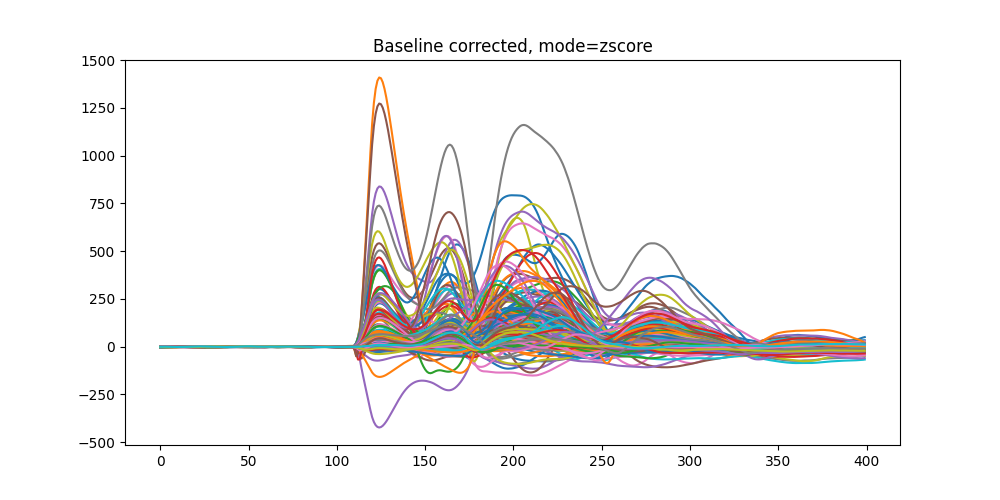

In [96]:
baseline_correction_mode = 'zscore'
corrected = mne.baseline.rescale(empirical['ts'].T, np.array([i for i in range(400)]), (0,99), mode=baseline_correction_mode).T

plot_data(corrected,title=f'Baseline corrected, mode={baseline_correction_mode}')

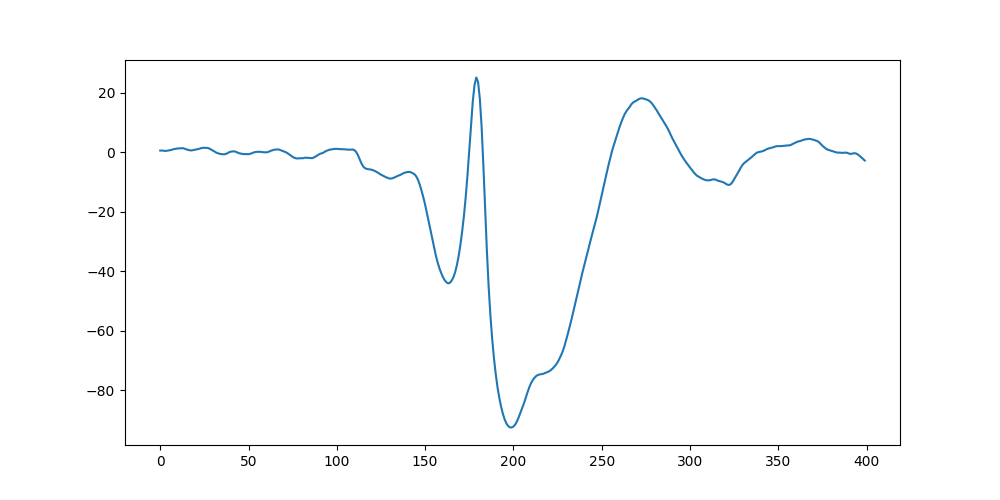

In [97]:
plot_one_roi(corrected,17)

In [114]:
def get_amplitude_first_peak(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold or val < -threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    while id_above_threshold < len(seqence) and (seqence[id_above_threshold] > threshold or seqence[id_above_threshold] < -threshold): 
        if seqence[id_above_threshold] > abs(max_value_above_threshold):
            max_value_above_threshold = abs(seqence[id_above_threshold])
        id_above_threshold += 1
    
    return max_value_above_threshold

def get_amplitude_highest_peak(seqence, threshold):
    val = seqence[np.argmax(np.abs(seqence))]

    if val > threshold or val < -threshold:
        return abs(val)
    return None

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if abs(v) > threshold:
            estimate += abs(v)

    if estimate > 0:
        return estimate

    return None

def get_threshold_range(corrected_data,stim_idx):
    # TODO předělat upper, protože takhle poslední dvě hodnoty nedávají smysl?

    upper = int(np.max(corrected_data[stim_idx:,:]))
    lower = int(np.max(corrected_data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

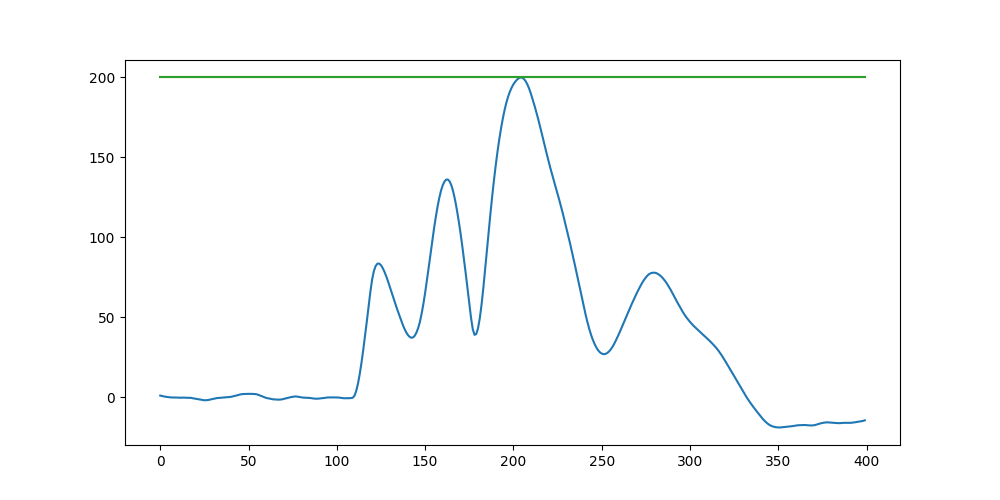

In [115]:
roi_idx = 1

amp = get_amplitude_first_peak(corrected[:,roi_idx],threshold=5)
amp_h = get_amplitude_highest_peak(corrected[:,roi_idx],threshold=5)

plot_one_roi(corrected,roi_idx,constants=[amp,amp_h])

In [116]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(corrected,stim_time)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200), columns=['01-response','amp_highest','amp_first'])

    maxima = np.max(corrected,axis=0)
    response_df['01-response'] = maxima > threshold
    response_df['amp_first'] = np.array([get_amplitude_first_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['amp_highest'] = np.array([get_amplitude_highest_peak(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)
    response_df['variance'] = np.var(corrected[stim_time:],axis=0)
    response_df['diff'] = np.max(corrected[stim_time:],axis=0)-np.min(corrected[stim_time:],axis=0)
    response_df['AUC_estimate'] = np.array([estimate_auc(corrected[stim_time:,i],threshold) for i in range(200)],dtype=float)

    responses[threshold] = response_df

In [117]:
def prepare_barcode(n_rows,n_cols):
    pixel_per_bar = 4
    dpi = 100

    return plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows), dpi=dpi, tight_layout=True)

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1)
    else:
        code = data.reshape(1,-1)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(title)

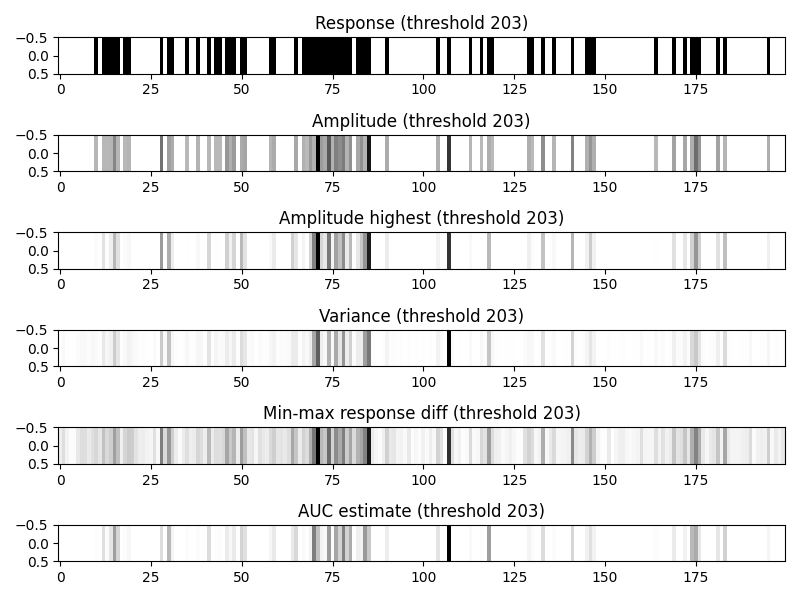

In [118]:
thr = list(responses.keys())[1]

fig, axs = prepare_barcode(6,200)

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response (threshold {thr})")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude (threshold {thr})")
plot_one_barcode(axs[2],responses[thr]['amp_highest'],title=f"Amplitude highest (threshold {thr})")
plot_one_barcode(axs[3],responses[thr]['variance'],title=f"Variance (threshold {thr})")
plot_one_barcode(axs[4],responses[thr]['diff'],title=f"Min-max response diff (threshold {thr})")
plot_one_barcode(axs[5],responses[thr]['AUC_estimate'],title=f"AUC estimate (threshold {thr})")

22


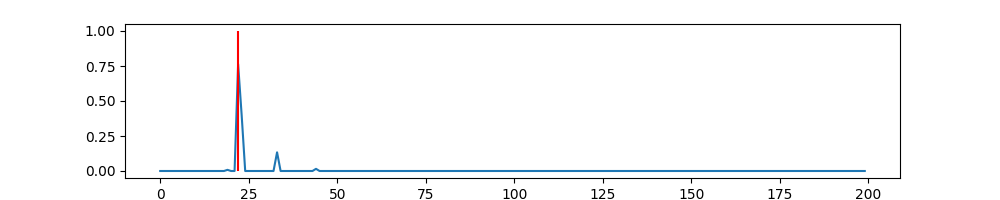

In [119]:
stim_weights = np.load('../data/external/pytepfit/stim_weights.npy')
stim_locatin = np.argmax(stim_weights)
print(stim_locatin)

plt.rcParams['figure.figsize'] = [10, 2]
plt.figure()
plt.plot(stim_weights)
plt.vlines(stim_locatin,0,1,colors='r')
plt.show()

### Load structural (and functional) connectivity data

ne domhof, ty parcelace jsou jiné

In [120]:
SC_W, SC_L, FC = data.load_pytepfit_sc()

SC_W = np.where(SC_W == 0,np.nan,SC_W)
SC_L = np.where(SC_L == 0,np.nan,SC_L)

Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

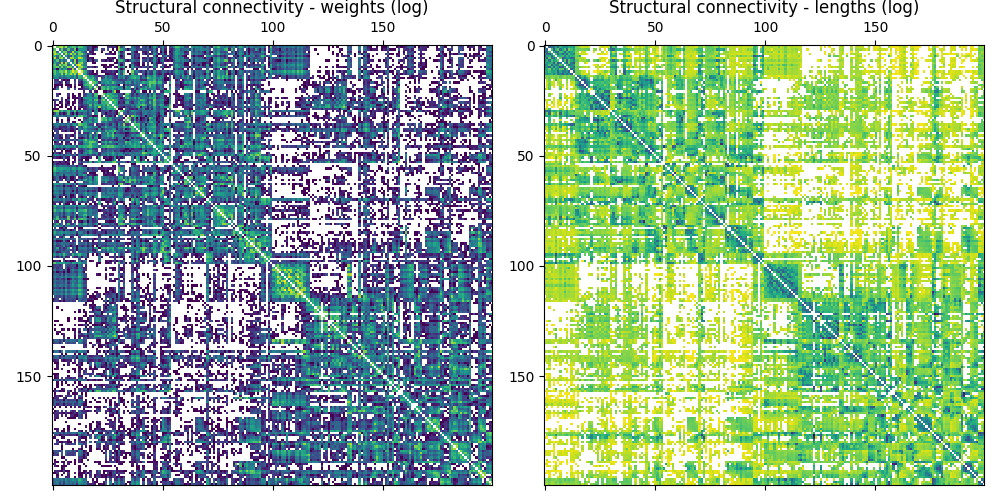

In [121]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

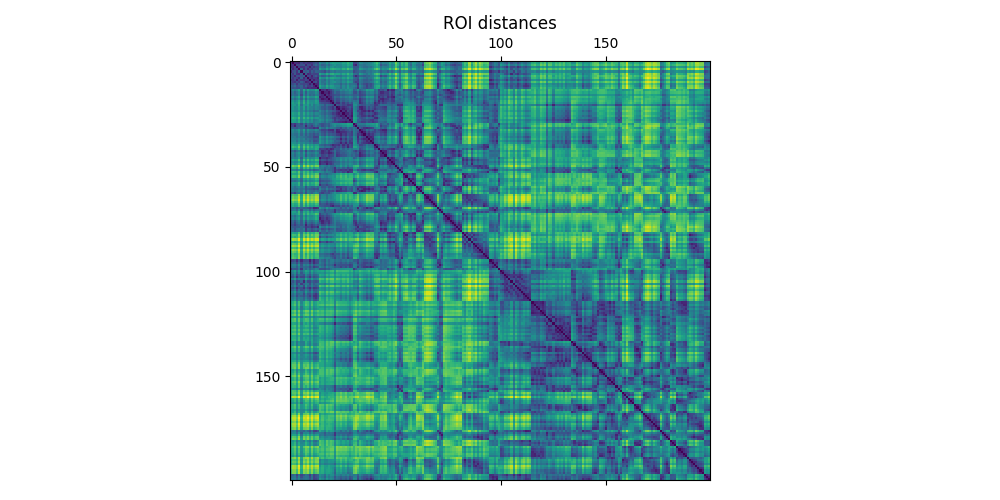

In [122]:
ED = data.schaefer_roi_distances(200)

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

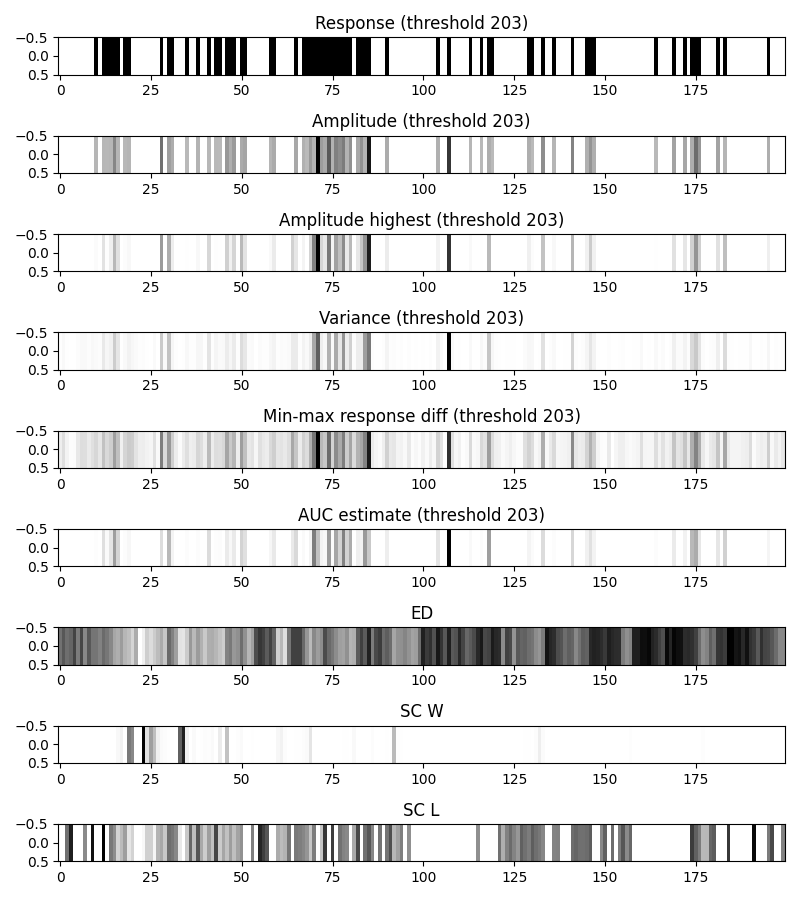

In [123]:
thr = list(responses.keys())[1]

fig, axs = prepare_barcode(9,200)

plot_one_barcode(axs[0],responses[thr]['01-response'],title=f"Response (threshold {thr})")
plot_one_barcode(axs[1],responses[thr]['amp_first'],title=f"Amplitude (threshold {thr})")
plot_one_barcode(axs[2],responses[thr]['amp_highest'],title=f"Amplitude highest (threshold {thr})")
plot_one_barcode(axs[3],responses[thr]['variance'],title=f"Variance (threshold {thr})")
plot_one_barcode(axs[4],responses[thr]['diff'],title=f"Min-max response diff (threshold {thr})")
plot_one_barcode(axs[5],responses[thr]['AUC_estimate'],title=f"AUC estimate (threshold {thr})")
plot_one_barcode(axs[6],ED[stim_locatin],title=f"ED")
plot_one_barcode(axs[7],SC_W[stim_locatin],title=f"SC W")
plot_one_barcode(axs[8],SC_L[stim_locatin],title=f"SC L")

## Correlations

In [124]:
PLOT=False

In [125]:
print(spearmanr(SC_W.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_L.flatten(),ED.flatten(),nan_policy='omit'))
print(spearmanr(SC_W.flatten(),SC_L.flatten(),nan_policy='omit'))

SignificanceResult(statistic=-0.43559387637609404, pvalue=0.0)
SignificanceResult(statistic=0.7049380439404286, pvalue=0.0)
SignificanceResult(statistic=-0.5897822038378862, pvalue=0.0)


In [126]:
# shortcut for correlation of X with response probability and amplitude 
def coor_with_response(X):
    s = pd.Series(X[stim_locatin])

    for threshold in thr_range:
        print(f"------------- THRESHOLD {threshold} -------------")
        response_df = responses[threshold]

        stat = pd.DataFrame(index=response_df.keys())
        
        stat['r'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[0])
        stat['p'] = response_df.corrwith(s,method=lambda x,y: spearmanr(x,y,nan_policy='omit')[1])
        stat['sigf'] = np.where(stat['p']<0.05,'*','-')

        stat['n_val'] = response_df.count(axis=0)
        print(stat)


# p-val https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

In [127]:
coor_with_response(ED)

------------- THRESHOLD 3 -------------
                     r         p sigf  n_val
01-response        NaN       NaN    -    200
amp_highest  -0.148453  0.035912    *    200
amp_first    -0.125469  0.076681    -    200
variance     -0.156668  0.026730    *    200
diff         -0.157359  0.026059    *    200
AUC_estimate -0.149569  0.034526    *    200
------------- THRESHOLD 203 -------------
                     r         p sigf  n_val
01-response  -0.079105  0.265514    -    200
amp_highest   0.009219  0.940979    -     67
amp_first     0.030689  0.805272    -     67
variance     -0.156668  0.026730    *    200
diff         -0.157359  0.026059    *    200
AUC_estimate  0.033003  0.790907    -     67
------------- THRESHOLD 403 -------------
                     r         p sigf  n_val
01-response  -0.051326  0.470429    -    200
amp_highest  -0.001709  0.993388    -     26
amp_first     0.037265  0.856578    -     26
variance     -0.156668  0.026730    *    200
diff         -0.15735

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [128]:
coor_with_response(SC_W) 

------------- THRESHOLD 3 -------------


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


                     r         p sigf  n_val
01-response        NaN       NaN    -    200
amp_highest   0.049482  0.602731    -    200
amp_first     0.013666  0.885763    -    200
variance      0.057882  0.542549    -    200
diff          0.072655  0.444414    -    200
AUC_estimate  0.066432  0.484486    -    200
------------- THRESHOLD 203 -------------
                     r         p sigf  n_val
01-response  -0.021881  0.818063    -    200
amp_highest  -0.173972  0.258723    -     67
amp_first    -0.098400  0.525126    -     67
variance      0.057882  0.542549    -    200
diff          0.072655  0.444414    -    200
AUC_estimate -0.120376  0.436371    -     67
------------- THRESHOLD 403 -------------
                     r         p sigf  n_val
01-response  -0.052035  0.584129    -    200
amp_highest  -0.169542  0.515349    -     26
amp_first    -0.114284  0.662293    -     26
variance      0.057882  0.542549    -    200
diff          0.072655  0.444414    -    200
AUC_estimate -0.

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [129]:
coor_with_response(SC_L) 

------------- THRESHOLD 3 -------------


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


                     r         p sigf  n_val
01-response        NaN       NaN    -    200
amp_highest   0.042701  0.653379    -    200
amp_first    -0.055260  0.561016    -    200
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate  0.010072  0.915677    -    200
------------- THRESHOLD 203 -------------
                     r         p sigf  n_val
01-response   0.076225  0.422296    -    200
amp_highest   0.102748  0.506886    -     67
amp_first     0.100211  0.517487    -     67
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate  0.114447  0.459461    -     67
------------- THRESHOLD 403 -------------
                     r         p sigf  n_val
01-response   0.077405  0.415129    -    200
amp_highest   0.240196  0.353089    -     26
amp_first     0.240196  0.353089    -     26
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate  0.

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


                     r         p sigf  n_val
01-response   0.112976  0.233491    -    200
amp_highest        NaN       NaN    -      3
amp_first          NaN       NaN    -      3
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate       NaN       NaN    -      3
------------- THRESHOLD 1203 -------------
                     r         p sigf  n_val
01-response   0.112976  0.233491    -    200
amp_highest        NaN       NaN    -      2
amp_first          NaN       NaN    -      2
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate       NaN       NaN    -      2
------------- THRESHOLD 1403 -------------


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


                     r         p sigf  n_val
01-response        NaN       NaN    -    200
amp_highest        NaN       NaN    -      1
amp_first          NaN       NaN    -      1
variance      0.028079  0.767823    -    200
diff         -0.000116  0.999023    -    200
AUC_estimate       NaN       NaN    -      1


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
